# Segment Classification Demo

This notebook demonstrates how to:
- Configure the Segmenter with custom parameters
- Classify detected segments by trend direction (up/down/horizontal)
- Filter segments by slope magnitude and volatility (standard deviation)
- Visualize specific segment categories

**Prerequisites:** `pip install trend-classifier yfinance`

## Setup and Configuration

In [200]:
import warnings

import pandas as pd
import yfinance as yf

from trend_classifier.configuration import CONFIG_REL
from trend_classifier.segmentation import Segmenter

warnings.filterwarnings("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [207]:
# Configure the segmenter parameters
cfg = CONFIG_REL
cfg.N = 80  # Window size for trend calculation
cfg.overlap_ratio = 0.33  # Overlap between adjacent windows
cfg.alpha = 0.5  # Weight for slope difference in segment merging
cfg.beta = 0.5  # Weight for offset difference in segment merging

## Download and Process Data

In [208]:
symbol = "AAPL"
df = yf.download(symbol, start="2018-09-15", end="2022-09-05", interval="1d", progress=False)

column = "Adj Close"
x_in = list(range(0, len(df.index.tolist()), 1))
y_in = df[column].tolist()

## Calculate and Visualize Segments

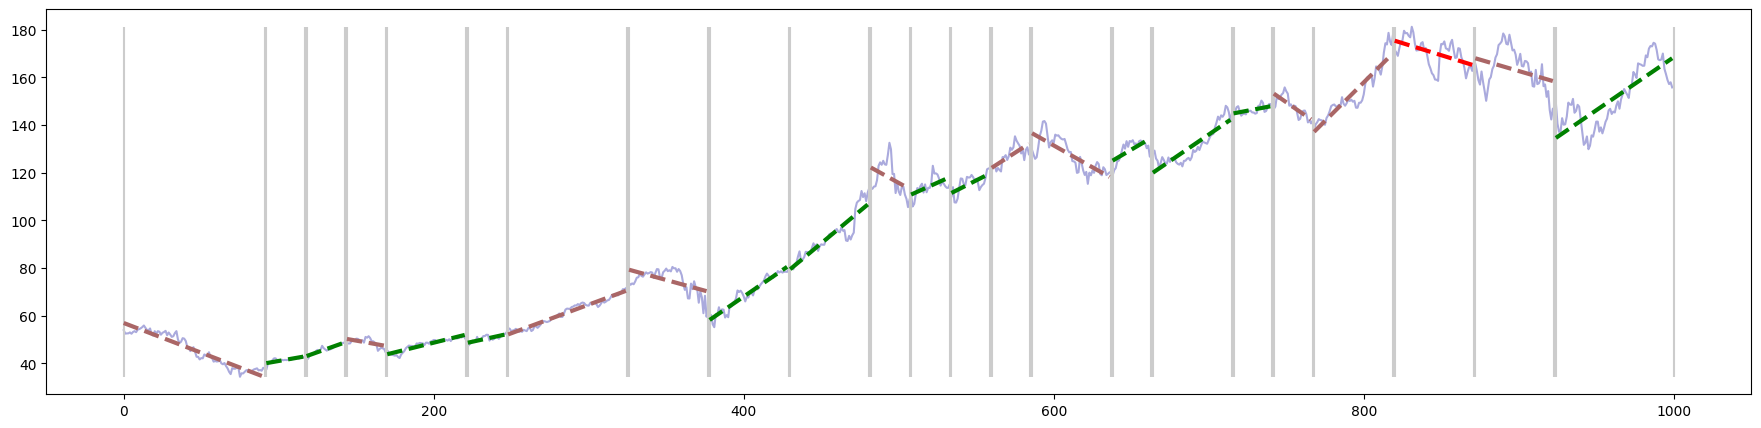

In [210]:
seg = Segmenter(x_in, y_in, cfg)
seg.calculate_segments()
seg.describe_segments()
seg.plot_segments(fig_size=(22, 5))

In [211]:
# View all detected segments
seg.segments

[Segment(0, 91, -0.247),
 Segment(92, 117, 0.1091),
 Segment(118, 143, 0.2269),
 Segment(144, 169, -0.1397),
 Segment(170, 221, 0.1569),
 Segment(222, 247, 0.1496),
 Segment(248, 325, 0.2419),
 Segment(326, 377, -0.1971),
 Segment(378, 429, 0.4424),
 Segment(430, 481, 0.557),
 Segment(482, 507, -0.398),
 Segment(508, 533, 0.268),
 Segment(534, 559, 0.3464),
 Segment(560, 585, 0.3769),
 Segment(586, 637, -0.3615),
 Segment(638, 663, 0.3173),
 Segment(664, 715, 0.4495),
 Segment(716, 741, 0.1204),
 Segment(742, 767, -0.4514),
 Segment(768, 819, 0.6659),
 Segment(820, 871, -0.2003),
 Segment(872, 923, -0.2192),
 Segment(924, 1000, 0.4458)]

## Analyze Segment Properties

Extract key properties from each segment for classification:
- **Slope**: Direction and magnitude of the trend
- **Std**: Standard deviation (volatility/noise within the segment)
- **Span**: Length of the segment

In [140]:
seg_list = []
for s in seg.segments:
    seg_list.append([s.slope, s.slopes_std, s.span])

df_segments = pd.DataFrame(seg_list, columns=["Slope", "Std", "Span"]).sort_values("Slope")
df_segments

In [180]:
df_segments.describe()

,Slope,Std,Span
18,-0.451402,0.000000,83.0
10,-0.397970,0.000000,202.0
14,-0.361521,0.055798,141.0
0,-0.246998,0.180849,205.0
21,-0.219170,0.371732,190.0
20,-0.200292,0.121436,113.0
7,-0.197095,0.208592,222.0
3,-0.139685,0.000000,109.0
1,0.109134,0.000000,100.0
17,0.120437,0.000000,34.0


## Segment Classification

Define thresholds for classifying segments:
- **SL_TH (Slope Threshold)**: Segments with |slope| < 0.2 are considered horizontal
- **STD_TH (Std Threshold)**: Segments with std < 0.1 are considered "clean" (low volatility)

In [189]:
SL_TH = 0.2  # Slope threshold for horizontal classification
STD_TH = 0.1  # Standard deviation threshold for volatility classification

,Slope,Std,Span
count,23.000000,22.000000,23.000000
mean,0.115656,0.084299,122.000000
std,0.327591,0.107232,51.383584
min,-0.451402,0.000000,34.000000
25%,-0.198693,0.000000,86.000000
50%,0.156923,0.017614,111.000000
75%,0.361629,0.175335,158.500000
max,0.665943,0.371732,222.000000


### Horizontal Segments - Low Volatility
Flat trends with consistent behavior (sideways consolidation)

In [181]:
df_horiz_low = df_segments.loc[(abs(df_segments.Slope) < SL_TH) & (df_segments.Std < STD_TH)]
idx = df_horiz_low.index.tolist()
if idx:
    seg.plot_segment(idx, fig_size=(15, 4))
else:
    print("No segments match this criteria")

### Horizontal Segments - High Volatility
Flat trends with high noise (choppy sideways movement)

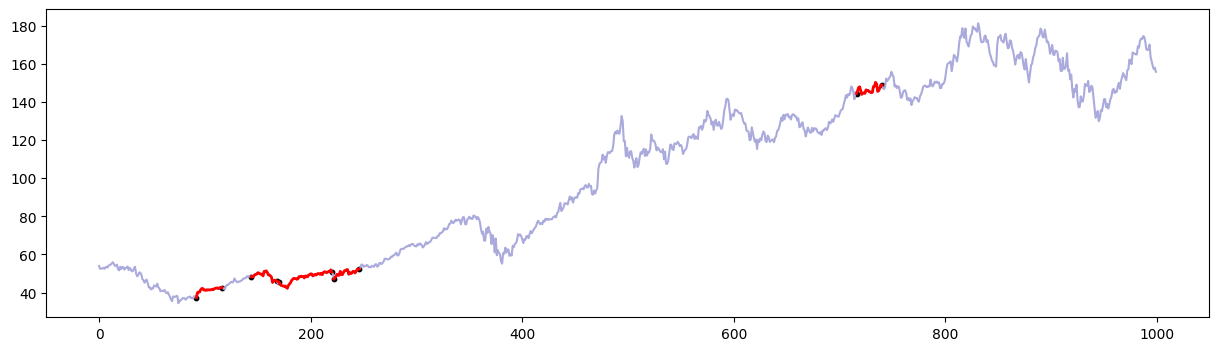

In [182]:
df_horiz_hi = df_segments.loc[(abs(df_segments.Slope) < SL_TH) & (df_segments.Std > STD_TH)]
idx = df_horiz_hi.index.tolist()
if idx:
    seg.plot_segment(idx, fig_size=(15, 4))
else:
    print("No segments match this criteria")

### Uptrend Segments - Low Volatility
Clean upward trends (strong bullish momentum)

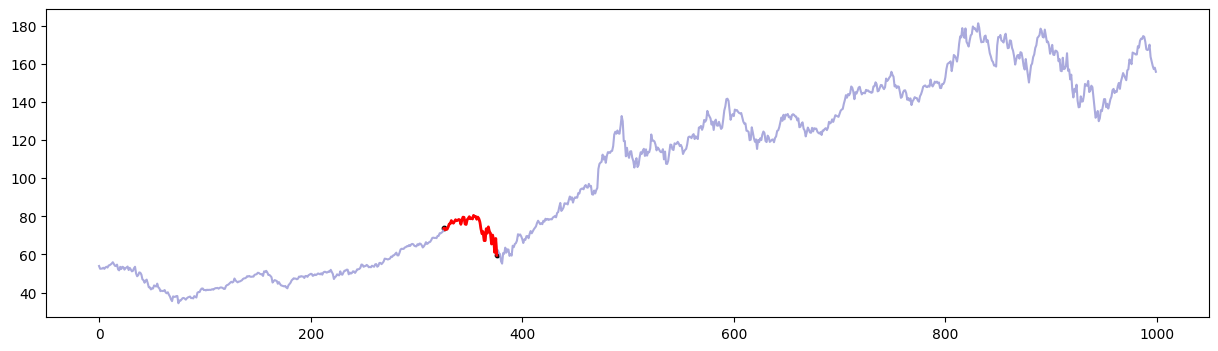

In [183]:
df_up_low = df_segments.loc[(df_segments.Slope > SL_TH) & (df_segments.Std < STD_TH)]
idx = df_up_low.index.tolist()
if idx:
    seg.plot_segment(idx, fig_size=(15, 4))
else:
    print("No segments match this criteria")

### Uptrend Segments - High Volatility
Volatile upward trends (bullish with high uncertainty)

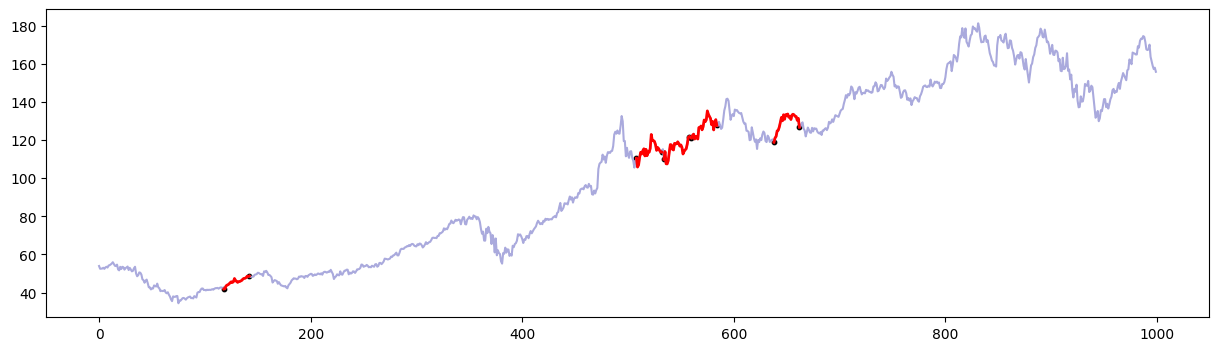

In [184]:
df_up_high = df_segments.loc[(df_segments.Slope > SL_TH) & (df_segments.Std > STD_TH)]
idx = df_up_high.index.tolist()
if idx:
    seg.plot_segment(idx, fig_size=(15, 4))
else:
    print("No segments match this criteria")

### Downtrend Segments - Low Volatility
Clean downward trends (strong bearish momentum)

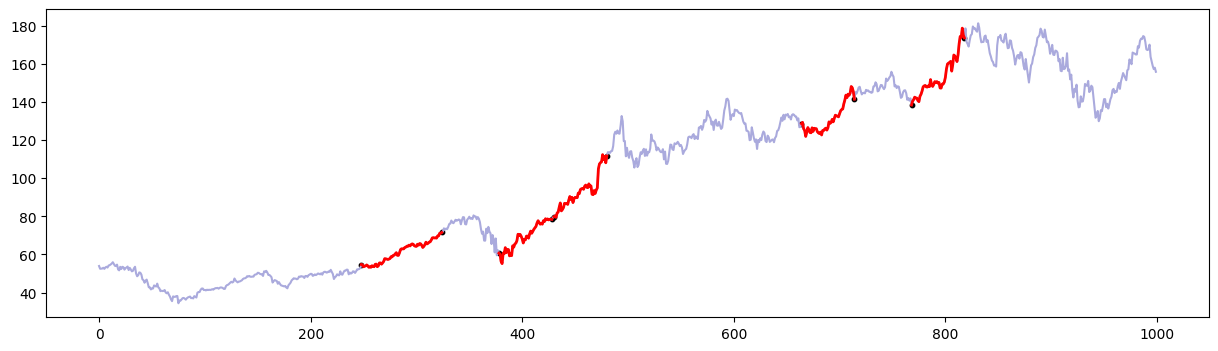

In [185]:
df_down_low = df_segments.loc[(df_segments.Slope < -SL_TH) & (df_segments.Std < STD_TH)]
idx = df_down_low.index.tolist()
if idx:
    seg.plot_segment(idx, fig_size=(15, 4))
else:
    print("No segments match this criteria")

### Downtrend Segments - High Volatility
Volatile downward trends (bearish with high uncertainty)

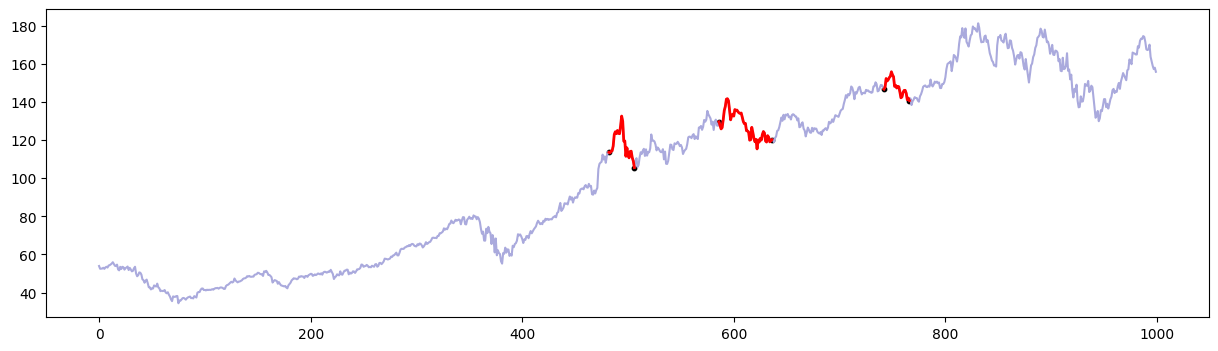

In [186]:
df_down_high = df_segments.loc[(df_segments.Slope < -SL_TH) & (df_segments.Std > STD_TH)]
idx = df_down_high.index.tolist()
if idx:
    seg.plot_segment(idx, fig_size=(15, 4))
else:
    print("No segments match this criteria")